In [1]:
import numpy as np
import pandas as pd

In [2]:
# Khởi tạo tham số cho mô hình
# Chi phí kho
O = 50.0 # Chi phí đặt hàng
h_year = 10.0 # Chi phí lưu trữ (10 đô cho 1 sản phẩm / năm)
b = 20.0 # Chi phí thiếu hàng (20 đô cho 1 mỗi sản phẩm tồn đọng)
LT = 1 # Lead Time = 1 ngày (đơn hàng được đặt hôm nay sẽ đến vào ngày kế tiếp)
days_per_year = 365 # Số ngày trong một năm
h = h_year/days_per_year # Chi phí lưu trữ quy đổi theo ngày
q = 6 # Số lượng đặt hàng mỗi lần
r = 3 # Mức tồn kho đặt hàng lại (reorder point)

# Nhu cầu
mu = 3.0        # Nhu cầu trung bình mỗi ngày
sigma = 1.0     # Độ lệch chuẩn của nhu cầu

# Tham số của Q-learning
alpha = 0.2 # Tốc độ học
gamma = 0.9 # Hệ số chiết khấu (0<gamma<1)
epsilon = 0.1 # Hệ số khám phá là 10%
num_episodes = 1000      # tổng số chu kỳ học
episode_length = 1000    # mỗi chu kỳ = 1000 ngày mô phỏng


In [3]:
# Môi trường học (state, action)

# Trạng thái: vị trí tồn kho (inventory position)
# Dải giá trị tồn kho [-20, 20] (âm = thiếu hàng)
min_IP, max_IP = -20, 20
states = np.arange(min_IP, max_IP + 1)

# Hành động: 0 = không đặt hàng, 1 = đặt hàng (số lượng q)
actions = [0, 1]

# Khởi tạo bảng Q-table (số trạng thái x số hành động)
Q = np.zeros((len(states), len(actions)))

def ip_to_index(ip):
    """Chuyển giá trị tồn kho sang chỉ số mảng Q-table """
    return int(np.clip(round(ip), min_IP, max_IP)) - min_IP


def sample_demand():
    """Tạo nhu cầu ngẫu nhiên theo phân phối chuẩn N(μ, σ), không âm."""
    d = np.random.normal(mu, sigma)
    return max(0, int(round(d)))


def step(ip, orders_in_transit, action):
    # Nhập hàng đến
    arrivals = 0
    if orders_in_transit > 0:
        arrivals = orders_in_transit
        orders_in_transit = 0

    # Cập nhật tồn kho sau khi nhận hàng
    ip_after_arrival = ip + arrivals

    # Trừ đi nhu cầu
    d = sample_demand()
    ip_after_demand = ip_after_arrival - d

    # Nếu hành động = đặt hàng → đơn hàng sẽ đến vào ngày sau
    order_placed = False
    # if action == 1:
    #     order_placed = True
    #     orders_in_transit = q
    
    # Chính sách đặt hàng: chỉ đặt hàng khi không có đơn hàng nào đang trên đường và tồn kho sau nhu cầu < r
    if orders_in_transit == 0 and (action == 1 or ip_after_demand < r):
        order_placed = True
        orders_in_transit = q  
    
    # Tính chi phí
    holding_cost = h * max(ip_after_demand, 0)
    backorder_cost = b * max(-ip_after_demand, 0)
    ordering_cost = O if order_placed else 0
    total_cost = holding_cost + backorder_cost + ordering_cost

    # Phần thưởng = -chi phí (RL muốn tối đa hóa reward)
    reward = -total_cost
    next_ip = ip_after_demand

    return next_ip, reward, orders_in_transit, total_cost


In [31]:
# -----------------------------
# 5️⃣ Vòng lặp huấn luyện Q-learning (epsilon cố định = 0.1, in log từng episode)
# -----------------------------
episode_costs = []
episode_holding = []
episode_backorder = []
episode_ordering = []

epsilon = 0.2  # Xác suất khám phá cố định

for ep in range(num_episodes):

    ip = r  # tồn kho ban đầu = điểm đặt hàng lại
    orders_in_transit = 0
    total_cost_ep = 0
    holding_ep = 0
    backorder_ep = 0
    ordering_ep = 0

    for day in range(episode_length):
        s_idx = ip_to_index(ip)

        # Epsilon-greedy: khám phá hoặc khai thác
        if np.random.rand() < epsilon:
            a = np.random.choice(actions)
        else:
            qvals = Q[s_idx, :]
            a = np.random.choice(np.flatnonzero(qvals == qvals.max()))

        # --- Mô phỏng một bước ---
        arrivals = 0
        if orders_in_transit > 0:
            arrivals = orders_in_transit
            orders_in_transit = 0

        ip_after_arrival = ip + arrivals
        d = sample_demand()
        ip_after_demand = ip_after_arrival - d

        order_placed = False
        if a == 1:
            order_placed = True
            orders_in_transit = q

        holding_cost = h * max(ip_after_demand, 0)
        backorder_cost = b * max(-ip_after_demand, 0)
        ordering_cost = O if order_placed else 0
        total_cost = holding_cost + backorder_cost + ordering_cost

        reward = -total_cost
        next_ip = ip_after_demand

        # --- Cập nhật Q-learning ---
        s_next = ip_to_index(next_ip)
        Q[s_idx, a] += alpha * (reward + gamma * np.max(Q[s_next, :]) - Q[s_idx, a])

        # --- Cộng dồn chi phí ---
        total_cost_ep += total_cost
        holding_ep += holding_cost
        backorder_ep += backorder_cost
        ordering_ep += ordering_cost

        ip = next_ip

    # Lưu kết quả của episode này
    episode_costs.append(total_cost_ep)
    episode_holding.append(holding_ep)
    episode_backorder.append(backorder_ep)
    episode_ordering.append(ordering_ep)

    # ✅ In ra từng episode
    print(f"Episode {ep + 1}/{num_episodes} | Tổng chi phí: {total_cost_ep:.2f} "
          f"(Holding={holding_ep:.2f}, Backorder={backorder_ep:.2f}, Ordering={ordering_ep:.2f})")

print("\n✅ Huấn luyện hoàn tất.")


Episode 1/1000 | Tổng chi phí: 8010520.08 (Holding=0.08, Backorder=7990120.00, Ordering=20400.00)
Episode 2/1000 | Tổng chi phí: 206201.04 (Holding=11.04, Backorder=181440.00, Ordering=24750.00)
Episode 3/1000 | Tổng chi phí: 182489.78 (Holding=9.78, Backorder=157080.00, Ordering=25400.00)
Episode 4/1000 | Tổng chi phí: 246342.88 (Holding=2.88, Backorder=221240.00, Ordering=25100.00)
Episode 5/1000 | Tổng chi phí: 257344.93 (Holding=4.93, Backorder=232040.00, Ordering=25300.00)
Episode 6/1000 | Tổng chi phí: 1480301.04 (Holding=1.04, Backorder=1456800.00, Ordering=23500.00)
Episode 7/1000 | Tổng chi phí: 6208980.00 (Holding=0.00, Backorder=6187580.00, Ordering=21400.00)
Episode 8/1000 | Tổng chi phí: 8458090.08 (Holding=0.08, Backorder=8437840.00, Ordering=20250.00)
Episode 9/1000 | Tổng chi phí: 8283970.03 (Holding=0.03, Backorder=8263520.00, Ordering=20450.00)
Episode 10/1000 | Tổng chi phí: 293024.68 (Holding=4.68, Backorder=268420.00, Ordering=24600.00)
Episode 11/1000 | Tổng chi p

In [32]:
# Trích xuất chính sách tối ưu từ Q-table
policy = np.argmax(Q, axis=1)  # chọn hành động tốt nhất ở mỗi trạng thái

In [33]:
# Mô phỏng đánh giá chính sách
def learned_policy(ip):
    """Chính sách do mô hình học được."""
    return int(policy[ip_to_index(ip)])


def rq_policy(ip):
    """Chính sách (r,q) truyền thống."""
    return 1 if ip <= r else 0


def evaluate(policy_func, days=365 * 5, seed=42):
    """Mô phỏng thực tế trong nhiều ngày để tính chi phí trung bình/ngày."""
    np.random.seed(seed)
    total_cost = 0
    ip = r
    orders_in_transit = 0
    for day in range(days):
        a = policy_func(ip)
        next_ip, _, orders_in_transit, cost = step(ip, orders_in_transit, a)
        ip = next_ip
        total_cost += cost
    return total_cost / days

In [34]:
# Đánh giá chính sách học được
learned_cost = evaluate(learned_policy)
rq_cost = evaluate(rq_policy)
reduction = (rq_cost - learned_cost) / rq_cost * 100

print(f"\n📊 Kết quả so sánh:")
print(f" - Chính sách học được: {learned_cost:.2f} €/ngày")
print(f" - Chính sách (r,q) truyền thống: {rq_cost:.2f} €/ngày")
print(f" - Tỷ lệ cải thiện: {reduction:.2f}%")


📊 Kết quả so sánh:
 - Chính sách học được: 26.49 €/ngày
 - Chính sách (r,q) truyền thống: 26.12 €/ngày
 - Tỷ lệ cải thiện: -1.40%


In [35]:
# Hiển thị chính sách học được
policy_df = pd.DataFrame({
    "inventory_position": states,
    "action (0=no order,1=order)": policy
})

print("\n🔎 Một phần của chính sách học được:")
print(policy_df)


🔎 Một phần của chính sách học được:
    inventory_position  action (0=no order,1=order)
0                  -20                            0
1                  -19                            1
2                  -18                            1
3                  -17                            1
4                  -16                            0
5                  -15                            0
6                  -14                            0
7                  -13                            1
8                  -12                            0
9                  -11                            0
10                 -10                            1
11                  -9                            0
12                  -8                            0
13                  -7                            0
14                  -6                            1
15                  -5                            0
16                  -4                            1
17                  -3     

In [36]:
# ===============================================================
# 🔟 Mô phỏng 30 ngày – đầy đủ các biến để quan sát (giống bài báo)
# ===============================================================
np.random.seed(123)
days = np.arange(1, 31)  # mô phỏng 30 ngày
ip = r
orders_in_transit = 0
records = []

for day in days:
    a = learned_policy(ip)   # hành động theo chính sách đã học
    d = sample_demand()      # nhu cầu ngẫu nhiên mỗi ngày
    arrivals = 0

    # Nếu hôm nay có hàng về (lead time = 1)
    if orders_in_transit > 0:
        arrivals = orders_in_transit
        orders_in_transit = 0

    inventory_before = ip
    ip_after = ip + arrivals - d

    # Nếu hôm nay đặt hàng, hàng sẽ đến ngày sau
    if a == 1:
        orders_in_transit = q

    # 🔹 Tính chi phí hằng ngày
    holding_cost = h * max(ip_after, 0)
    backorder_cost = b * max(-ip_after, 0)
    ordering_cost = O if a == 1 else 0
    total_cost = holding_cost + backorder_cost + ordering_cost

    # Ghi lại dữ liệu từng ngày
    records.append({
        "day": day,
        "demand": d,
        "inventory_before": inventory_before,
        "order_action": a,
        "arrivals_today": arrivals,
        "inventory_after": ip_after,
        "daily_cost": total_cost
    })

    ip = ip_after

# 🔸 Tạo DataFrame kết quả
df_sim = pd.DataFrame(records)
print("\n📅 Dữ liệu mô phỏng 30 ngày đầu:")
print(df_sim.to_string(index=False))


📅 Dữ liệu mô phỏng 30 ngày đầu:
 day  demand  inventory_before  order_action  arrivals_today  inventory_after  daily_cost
   1       2                 3             0               0                1    0.027397
   2       4                 1             0               0               -3   60.000000
   3       3                -3             0               0               -6  120.000000
   4       1                -6             1               0               -7  190.000000
   5       2                -7             0               6               -3   60.000000
   6       5                -3             0               0               -8  160.000000
   7       1                -8             0               0               -9  180.000000
   8       3                -9             0               0              -12  240.000000
   9       4               -12             0               0              -16  320.000000
  10       2               -16             0               0       

In [37]:
import matplotlib.pyplot as plt

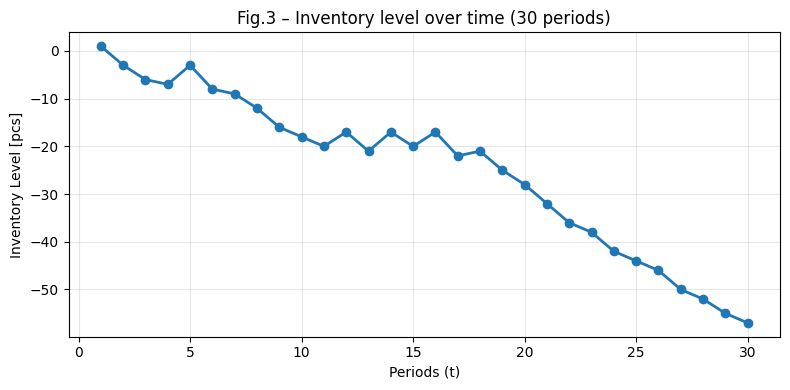

In [38]:
# ===============================================================
# 📈 Fig.3 – Inventory Level (Pcs)
# ===============================================================
plt.figure(figsize=(8,4))
plt.plot(df_sim["day"], df_sim["inventory_after"], marker='o', color='tab:blue', linewidth=2)
plt.xlabel("Periods (t)")
plt.ylabel("Inventory Level [pcs]")
plt.title("Fig.3 – Inventory level over time (30 periods)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

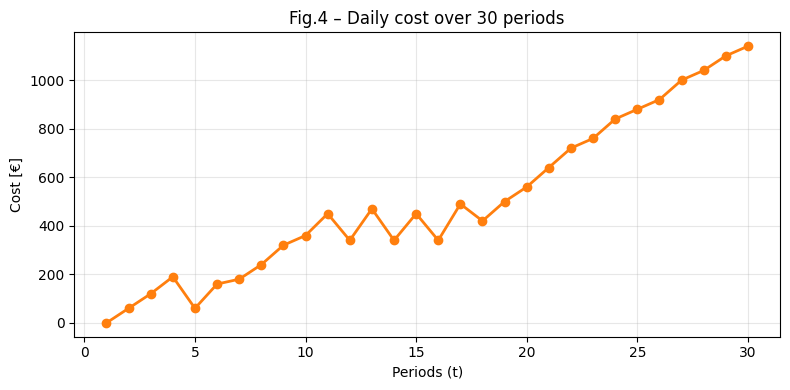

In [39]:
# ===============================================================
# 💰 Fig.4 – Cost (€)
# ===============================================================
plt.figure(figsize=(8,4))
plt.plot(df_sim["day"], df_sim["daily_cost"], marker='o', color='tab:orange', linewidth=2)
plt.xlabel("Periods (t)")
plt.ylabel("Cost [€]")
plt.title("Fig.4 – Daily cost over 30 periods")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()